https://github.com/iolucas/dlnd-projects/blob/master/image-classification/dlnd_image_classification.ipynb


In [1]:
import math
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline
import os
from collections import Counter

from sklearn.model_selection import train_test_split

from data_manager import load_dataset

import json

import psycopg2

import random

import pickle

In [2]:
class StrokesDataset:
    def __init__(self, db_addr="localhost"):
        #Connect to db
        self.conn = psycopg2.connect("dbname='postgres' user='postgres' host='{}' password='lucas'".format(db_addr))
        self.cur = self.conn.cursor()
        
        #Retrieve and cache ids list to use to query data later
        self.cur.execute("SELECT id FROM samples LIMIT 300000")
        id_list = self.cur.fetchall()
        self.id_cache = [id_value[0] for id_value in id_list]
        
        #Lets save key_to_ind to ensure the labels will be in the same order all the time
        #Try to load key_to_ind, if not succeed, get it and save it
        try:
            key_list = pickle.load(open("key_list.pickle", "rb"))
            #self.key_to_ind = pickle.load(open("key_to_ind.pickle", "rb"))
            print("Loaded key_list file.")
        except:
            #Retrieve and cache labels
            self.cur.execute("SELECT DISTINCT key FROM samples LIMIT 300000")
            key_list = [key_value[0] for key_value in self.cur.fetchall()]
            pickle.dump(key_list, open("key_list.pickle", "wb"), protocol=pickle.HIGHEST_PROTOCOL)
            print("Generated new key_list file.")
            
        self.key_to_ind = dict([(key, ind) for ind, key in enumerate(key_list)])
        self.ind_to_key = key_list
            
            
        
        
    def get_train_valid_test_ids(self):
        train_ids, valid_ids = train_test_split(self.id_cache, test_size=0.4)
        valid_ids, test_ids = train_test_split(valid_ids, test_size=0.5)
        return tuple(train_ids), tuple(valid_ids), tuple(test_ids)
    
    def DEPRECTED_get_batches(self, ids, batch_size):
        assert batch_size < 5000
        
        self.cur.execute("SELECT key, strokes FROM samples WHERE id in {}".format(ids))
       
        while True:
            data_batch = self.cur.fetchmany(batch_size)
            if len(data_batch) == 0:
                break
                
            ziped = list(zip(*data_batch)) #Use zip to separate labels from datapoints
            
            yield ziped[1], ziped[0]
            
    def get_batches(self, ids, batch_size):
        assert batch_size < 5000
        
        for i in range(0,len(ids), batch_size):        
            self.cur.execute("SELECT key, strokes FROM samples WHERE id in {}".format(ids[i:i+batch_size]))
       
            data_batch = self.cur.fetchall()
                
            ziped = list(zip(*data_batch)) #Use zip to separate labels from datapoints
            
            yield ziped[1], ziped[0]   

In [3]:
def draw_image(strokes_list):
    im = Image.new(mode="1", size=(500,500))

    draw = ImageDraw.Draw(im)
    #draw.moveTo(strokes[0][:2], fill=128)
    #print(strokes)
    #draw.line((0, 0) + im.size, fill=128)
    #draw.line((0, im.size[1], im.size[0], 0), fill=128)
    for strokes in strokes_list:
        draw.line(strokes, fill=128, width=5)
    
    
    #for stroke in strokes[0:]:
        #print(stroke.tolist())
        #draw.line(stroke, fill=128, width=10)

    plt.imshow(im)

# write to stdout
#im.save(sys.stdout, "PNG")

In [4]:
def gen_tuples(strokes_list):
    strokes_group = list()
    for strokes in strokes_list:
        strokes_tuples = list()
        for x,y,t in strokes:
            strokes_tuples.append((x,y))
        strokes_group.append(strokes_tuples)
    return strokes_group

In [5]:
def gen_random_tuple(size):
    assert size < 100000
    rand_list = list()
    while len(rand_list) < size:
        rand_value = random.randint(1,50000)
        if rand_value not in rand_list:
            rand_list.append(rand_value)
        
    return tuple(rand_list)

In [6]:
ds = StrokesDataset("189.62.80.32")

Loaded key_list file.


In [7]:
ds.key_to_ind[ds.ind_to_key[1097]]

1097

In [8]:
trainset, validset, testset = ds.get_train_valid_test_ids()

Wall time: 6.67 s
upgreek-OT1-_uptau


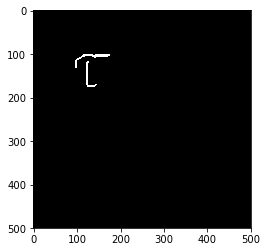

In [9]:
%time test_batch = next(ds.get_batches(trainset,1000))
draw_image(gen_tuples(test_batch[0][59]))
print(test_batch[1][59])

In [10]:
def transform_data(strokes_list):
    """Convert strokes to match (deltaX, deltaY, is_drawing, is_moving, is_finished)"""
    
    onehots = list() #Gen pen moving onehots
    flatten_strokes = [[0,0,0]] #Reshape strokes lists
    
    for strokes in strokes_list:
        strokes = sorted(strokes, key=lambda a: a.__getitem__(2), reverse=False) #ensure strokes are in order
        flatten_strokes += strokes
        strokes_onehots = [[0,1,0]] + [[1,0,0]]*(len(strokes)-1)
        onehots += strokes_onehots
       
    #Set end flag at the last coordinate
    onehots[-1] = [0,0,1]
        
    flatten_strokes = np.array(flatten_strokes)
    delta_strokes = flatten_strokes[1:,:2] - flatten_strokes[:-1,:2] #Get delta values (:2 removes the timing data)
    
    np_batch = np.concatenate((delta_strokes, onehots), axis=1)
    
    return np_batch.astype(int)
    
%time transform_data(test_batch[0][600])
#draw_image(gen_tuples(test_batch[0][600]))

Wall time: 0 ns


array([[ 93, 105,   0,   1,   0],
       [  1,   0,   1,   0,   0],
       [  3,   0,   1,   0,   0],
       [  2,  -1,   1,   0,   0],
       [  4,  -1,   1,   0,   0],
       [  4,   0,   1,   0,   0],
       [  4,  -1,   1,   0,   0],
       [  4,   0,   1,   0,   0],
       [  2,   0,   1,   0,   0],
       [  3,   0,   1,   0,   0],
       [  1,   0,   1,   0,   0],
       [  2,   0,   1,   0,   0],
       [  2,   0,   1,   0,   0],
       [  1,   0,   1,   0,   0],
       [  2,   0,   1,   0,   0],
       [  2,   0,   1,   0,   0],
       [  1,   0,   1,   0,   0],
       [  1,   0,   1,   0,   0],
       [-37,  12,   0,   1,   0],
       [  1,   0,   1,   0,   0],
       [  3,   0,   1,   0,   0],
       [  5,   0,   1,   0,   0],
       [  4,   0,   1,   0,   0],
       [  4,   0,   1,   0,   0],
       [  4,   0,   1,   0,   0],
       [  3,   0,   1,   0,   0],
       [  2,   0,   1,   0,   0],
       [  2,   0,   1,   0,   0],
       [  2,   1,   1,   0,   0],
       [  1,  

https://www.tensorflow.org/tutorials/recurrent_quickdraw<br>
https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicLSTMCell<br>
https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper<br>
https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/MultiRNNCell<br>
https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/stack_bidirectional_dynamic_rnn<br>
https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py<br>
https://github.com/udacity/deep-learning/blob/master/intro-to-rnns/Anna_KaRNNa_Solution.ipynb<br>
https://github.com/tensorflow/magenta/tree/master/magenta/models/sketch_rnn<br>

In [11]:
def _add_cudnn_rnn_layers(convolved, num_nodes, num_layers, keep_prob):
    """Adds CUDNN LSTM layers."""
    # Convolutions output [B, L, Ch], while CudnnLSTM is time-major.
    convolved = tf.transpose(convolved, [1, 0, 2])
    lstm = tf.contrib.cudnn_rnn.CudnnLSTM(
        input_size=5,
        num_layers=num_layers,
        num_units=num_nodes,
        dropout=keep_prob,
        direction="bidirectional")
    outputs, _ = lstm(convolved)
    # Convert back from time-major outputs to batch-major outputs.
    outputs = tf.transpose(outputs, [1, 0, 2])
    return outputs

In [ ]:
def create_rnn_cell(lstm_size, keep_prob):
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    cell = tf.contrib.rnn.DropoutWrapper(lstm, input_keep_prob=keep_prob)
    return cell

In [ ]:
tf.reset_default_graph()

#Create network
lstm_size = 128
num_layers = 2
grad_clip = 9.0
learning_rate = 0.01
n_classes = len(ds.key_to_ind)

inputs = tf.placeholder(tf.float32, shape=[None, None, 5], name="inputs")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

targets = tf.placeholder(tf.int32, shape=[None], name="targets")

targets_onehot = tf.one_hot(targets, n_classes)


rnn_outputs = _add_cudnn_rnn_layers(inputs, lstm_size, num_layers, keep_prob)


#fw_cells = [create_rnn_cell(lstm_size, keep_prob)] #Forwards cells
#bw_cells = [create_rnn_cell(lstm_size, keep_prob)] #Backwards cells

#rnn_outputs, output_state_fw, output_state_bw = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(
    #fw_cells, bw_cells, inputs, dtype=tf.float32)

#Use [:,-1,:] to keep only the (batches, last outputs, classes)
logits = tf.layers.dense(rnn_outputs[:,-1,:], n_classes)

outputs = tf.nn.softmax(logits)

loss = tf.nn.softmax_cross_entropy_with_logits(labels=targets_onehot, logits=logits)
loss = tf.reduce_mean(loss)

#Create optimizers
#optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

# Optimizer for training, using gradient clipping to control exploding gradients
tvars = tf.trainable_variables()
grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
train_op = tf.train.AdamOptimizer(learning_rate)
optimizer = train_op.apply_gradients(zip(grads, tvars))

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(targets_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [195]:
def get_batches(dataset, batch_size):
    for x_batch, y_batch in ds.get_batches(dataset, batch_size):
        #Transform X data to get delta cordinates, 
        trans_x = list(map(transform_data, x_batch))
        
        #make them the same size of the max size        
        max_size = max(map(len, trans_x))
        x_data_buffer = np.array([0,0,0,0,1]) * np.ones((batch_size, max_size, 5)).astype(int)
        for i, x_transf_data in enumerate(trans_x):
            x_data_buffer[i][:len(x_transf_data)] = x_transf_data
        
        #transform y data to get indexes for each label
        yield x_data_buffer, list(map(ds.key_to_ind.get, y_batch))
 
#Test
#%time testdata = next(get_batches(trainset, 5))
#print(testdata[0].shape)

In [196]:
#%time draw_image(gen_tuples(next(test_batches)[0][8]))

In [197]:
len(trainset)

126272

In [246]:
epochs = 1
batch_size = 256

sess = tf.Session()

sess.run(tf.global_variables_initializer())

loss_buffer = list()

for e in range(epochs):
    
    for X_batch, Y_batch in get_batches(trainset, batch_size):
            
        loss_value, _ = sess.run([loss, optimizer], feed_dict={
            inputs: X_batch,
            keep_prob: 1,
            targets: Y_batch
        })
        
        loss_buffer.append(loss_value)        
        print(loss_value)
        
        
        print("Working on accuracy...")
        #Check accuracy
        acc_list = list()
        for X_valid, Y_valid in get_batches(validset, 1000):
            
            print("Calculating acc...")
            
            accuracy_value = sess.run(accuracy, feed_dict={
                inputs: X_valid,
                keep_prob: 1,
                targets: Y_valid
            })
            
            acc_list.append(accuracy_value)
            
        valid_accuracy = sum(acc_list) / len(acc_list)     
        print(valid_accuracy)

    #acc_value = sess.run([accuracy], feed_dict={
        #inputs: X_valid,
        #targets: y_valid
    #})
    
    #print(e, loss_value, acc_value)

7.00336
Working on accuracy...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...
Calculating acc...


InvalidArgumentError: Incompatible shapes: [1000] vs. [91]
	 [[Node: Equal = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"](ArgMax, ArgMax_1)]]

Caused by op 'Equal', defined at:
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-244-8dc58c883e7d>", line 41, in <module>
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(targets_onehot, 1))
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 672, in equal
    result = _op_def_lib.apply_op("Equal", x=x, y=y, name=name)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\du0x\Anaconda2\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [1000] vs. [91]
	 [[Node: Equal = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/cpu:0"](ArgMax, ArgMax_1)]]
